# Feature: Display frequently mentioned keywords of restaurants within the same categories in New Orleans using tf-idf

v1: Train model on new_orleans_reviews from filtered category in New Orleans

## Import modules & load `new_orleans_reviews` and `new_orleans_restaurants` dataset

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as mp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
from PIL import Image  # pillow == 9.5

In [2]:
# load `new_orleans_reviews` dataset
new_orleans_reviews = pd.read_csv('../csv/new_orleans_reviews.csv')

In [3]:
print(new_orleans_reviews.columns)

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


In [4]:
# load `new_orleans_restaurants` dataset
new_orleans_business = pd.read_csv('../csv/new_orleans_restaurants.csv')

In [5]:
print(new_orleans_business.columns)
new_orleans_business.head(1)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,W4ZEKkva9HpAdZG88juwyQ,Mr. B's Bistro,201 Royal St,New Orleans,LA,70130,29.954387,-90.068363,4.0,2064,1,"{'NoiseLevel': ""u'average'"", 'RestaurantsReser...","Bars, Breakfast & Brunch, Restaurants, Barbequ...","{'Wednesday': '11:30-20:0', 'Thursday': '11:30..."


## Filter `new_orleans_business` dataset

In [6]:
# check shape of new_orleans_business
new_orleans_business.shape # 88 businesses in New Orleans

(88, 14)

In [7]:
# filter out businesses that are not restaurant
new_orleans_restaurants = new_orleans_business[new_orleans_business['categories'].str.contains('restaurant', case=False, na=False)]
new_orleans_restaurants.shape

(82, 14)

## Actual Workflow

- pick a random restaurant as example from `new_orleans_restaurants` dataset

1. WordCloud of other restaurants in the same category
    - call `res_in_same_cat` function
            - figure out what category this restaurant is in
            - pick the first category in the list (if category is 'restaurants', second one will be used)
            - display dataframe of other restaurants in the same category
    - merge with `new_orleans_reviews` dataset
    - Process `new_orleans_reviews`
    - train tf-idf model on words from reviews in that particular category (exclude user's restaurant)
    - generate WordCloud
    
    
2. WordCloud of user's own restaurant `sample_restaurant`
    - merge single restaurant with `new_oreleans_reviews` dataset
    - Process `restaurant_reviews`
    - transform `restaurant_reviews` using the tf-idf model trained on other restaurants in the same category
    generate WordCloud

In [8]:
# testing on one restaurant -> 'Mother's Restaurant'
sample_restaurant = new_orleans_restaurants[new_orleans_restaurants['name'] == "Mother's Restaurant"]
sample_restaurant

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
55,iSRTaT9WngzB8JJ2YKJUig,Mother's Restaurant,401 Poydras St,New Orleans,LA,70130,29.949057,-90.067049,3.5,5185,1,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', '..."


In [9]:
def res_in_same_cat(res_name:str) -> pd.DataFrame:
    """
    Get dataframe of other restaurants in same category, excluding user's restaurant
    First category from categories is picked.
    If first category is "Restaurants", second category will be used.
    
    """
    categories = new_orleans_restaurants.loc[new_orleans_restaurants['name'] == res_name]['categories']
    
    # convert series to string and split string to access first label (assumption)
    cat = categories.to_list()[0].split(", ")[0]
    print(cat)
    if cat == 'Restaurants':
        cat = categories.to_list()[0].split(", ")[1]
        print(cat)
    
    return new_orleans_restaurants.loc[(new_orleans_restaurants['categories'].str.contains(cat, case=False))
                                                 & (new_orleans_restaurants['name'] != res_name)]

In [10]:
# test function with our sample restaurant
same_cat_restaurants = res_in_same_cat("Mother's Restaurant")
same_cat_restaurants

Cajun/Creole


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,W4ZEKkva9HpAdZG88juwyQ,Mr. B's Bistro,201 Royal St,New Orleans,LA,70130,29.954387,-90.068363,4.0,2064,1,"{'NoiseLevel': ""u'average'"", 'RestaurantsReser...","Bars, Breakfast & Brunch, Restaurants, Barbequ...","{'Wednesday': '11:30-20:0', 'Thursday': '11:30..."
2,pym7c6ZFEtmoH16xN2ApBg,Katie's Restaurant & Bar,3701 Iberville St,New Orleans,LA,70119,29.973094,-90.095914,4.5,1289,1,"{'RestaurantsGoodForGroups': 'True', 'Alcohol'...","Restaurants, Bars, Nightlife, American (Tradit...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
3,SJIQFKTW6uUsOo29w9IHxw,Mambo's,411 Bourbon St,New Orleans,LA,70130,29.956668,-90.067651,4.0,1223,1,"{'Corkage': 'False', 'GoodForKids': 'True', 'C...","Cocktail Bars, Soul Food, Nightlife, Food, Des...","{'Monday': '11:0-1:0', 'Tuesday': '11:0-1:0', ..."
4,JvawJ9bSr22xn4R9oLvl_w,Desire Oyster Bar,300 Bourbon St,New Orleans,LA,70130,29.955527,-90.068154,4.0,1084,1,"{'RestaurantsAttire': ""'casual'"", 'Restaurants...","Southern, Event Planning & Services, Restauran...","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."
6,GBTPC53ZrG1ZBY3DT8Mbcw,Luke,333 Saint Charles Ave,New Orleans,LA,70130,29.950742,-90.070416,4.0,4554,1,"{'RestaurantsReservations': 'True', 'Restauran...","German, Restaurants, Seafood, Cocktail Bars, F...","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."
8,I6L0Zxi5Ww0zEWSAVgngeQ,Cafe Beignet on Bourbon Street,311 Bourbon St,New Orleans,LA,70130,29.955845,-90.068436,3.5,1066,1,"{'GoodForKids': 'True', 'OutdoorSeating': 'Tru...","Sandwiches, Breakfast & Brunch, Cajun/Creole, ...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-15:0', '..."
10,S2Ho8yLxhKAa26pBAm6rxA,Creole House Restaurant & Oyster Bar,509 Canal St,New Orleans,LA,70130,29.952213,-90.067116,4.0,1594,1,"{'WiFi': ""'free'"", 'RestaurantsAttire': ""u'cas...","Cajun/Creole, Seafood, Restaurants, Breakfast ...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."
13,Zi-F-YvyVOK0k5QD7lrLOg,Muriel's Jackson Square,801 Chartres St,New Orleans,LA,70116,29.958458,-90.063188,4.0,1963,1,"{'RestaurantsGoodForGroups': 'True', 'NoiseLev...","Cajun/Creole, Restaurants","{'Monday': '15:0-21:30', 'Tuesday': '15:0-21:3..."
15,mhrW9O0O5hXGXGnEYBVoag,Jacques-Imo's Cafe,8324 Oak St,New Orleans,LA,70118,29.949042,-90.132229,4.5,2406,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Seafood, Cajun/Creole, Restaurants, Vegetarian","{'Monday': '0:0-0:0', 'Wednesday': '17:0-21:0'..."
17,OCzo8T-76iJ_QVB2UX5SEQ,Killer Poboys,811 Conti St,New Orleans,LA,70112,29.956632,-90.067897,4.0,1006,1,"{'WiFi': ""u'free'"", 'HasTV': 'True', 'Alcohol'...","American (New), Sandwiches, Food, Cajun/Creole...","{'Monday': '12:0-20:0', 'Wednesday': '12:0-20:..."


## Merge `new_orleans_reviews` with `same_cat_restaurants`

In [11]:
# merge `reviews` with `same_cat_business` on business_id
same_cat_reviews = pd.merge(new_orleans_reviews, 
                         same_cat_restaurants, on='business_id')
same_cat_reviews.shape

(103393, 22)

## Preprocess `same_cat_reviews` 

In [12]:
# Cleaning text
def clean(text):
    
    # Remove Punctuation
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') 
    
    # Lower Case
    lowercased = text.lower()
    
    # Tokenize
    tokenized = word_tokenize(lowercased)

    # Remove numbers
    words_only = [word for word in tokenized if word.isalpha()]

    # Make stopword list
    stop_words = set(stopwords.words('english')) 

    # Remove Stop Words
    without_stopwords = [word for word in words_only if not word in stop_words]
    
    return " ".join(without_stopwords)

In [13]:
# Apply function to every review in same_cat_reviews
same_cat_reviews['clean_text'] = same_cat_reviews['text'].apply(clean)

same_cat_reviews.shape

(103393, 23)

In [14]:
# checking clean_text
print(same_cat_reviews.iloc[0].clean_text)

service crappy food mediocre wish would picked place last dinner town


## Train tf-idf model on `same_cat_reviews`

In [15]:
# Vectorize (tf-idf), ignoring terms that appear in less than 1% of all texts
vectorizer = TfidfVectorizer(ngram_range=(2,3),min_df=0.01).fit(same_cat_reviews.clean_text)

### Transform `same_cat_reviews` into their TF-IDF representation using the vocabulary and IDF weights learned during fitting

In [16]:
vectors = pd.DataFrame(vectorizer.transform(same_cat_reviews.clean_text).toarray(),
                      columns = vectorizer.get_feature_names_out())
vectors.head()

,across street,also ordered,amazing food,back next,bananas foster,bbq shrimp,beans rice,best ever,best meal,bloody mary,...,tourist trap,trip new,trip new orleans,turtle soup,wait staff,well worth,worth wait,would definitely,would go,would recommend
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# frequency score
sum_tfidf = vectors.sum(axis=0).sort_values(ascending=False)
sum_tfidf

new orleans            9129.428163
bread pudding          3200.633255
po boy                 2961.708801
chargrilled oysters    2547.101267
shrimp grits           2545.676147
                          ...     
definitely come         530.179129
trip new                506.636850
shell crab              506.473999
trip new orleans        504.222080
soft shell crab         491.939850
Length: 121, dtype: float64

In [18]:
# create a sorted tf-idf list from vocabulary and corresponding tf-idf scores
tfidf_list = [(word, sum_tfidf[word]) for word, idx in vectorizer.vocabulary_.items()]
sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)

In [19]:
def remove_meaningless_words(list_of_tuples) -> tuple[str, float]:
    """
    Remove meaningless words from a list of (word, score) tuples.

    Parameters:
    - sorted_tfidf_list: List of tuples, where each tuple is (word, score).
    """
    # Define the set of meaningless words to be removed
    meaningless_words = {
        'new orleans', 'food came', 'back next', 'right next', 
        'tasted like', 'gave us', 'next door', 'even though',
        'time new', 'decided try', 'canal street', 'make sure',
        'time new orleans', 'new orleans food', 'made us', 'place eat', 
        'took minutes', 'across street', 'go wrong', 'wait staff', 
        'food always', 'place go', 'minute wait', 'wait go', 'told us', 
        'neighborhood restaurant'
    }
    
    # Filter the list to exclude meaningless words
    return [(word, score) for word, score in sorted_tfidf_list if word not in meaningless_words] 

In [20]:
tfidf_list_clean = remove_meaningless_words(sorted_tfidf_list)

> The higher the resulting TF-IDF score, the more significant the word is considered to be in the context of that document compared to other words

### Transform reviews from user's restaurant into their TF-IDF representation using the vocabulary and IDF weights learned during fitting on `same_cat_reviews`

In [21]:
sample_restaurant

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
55,iSRTaT9WngzB8JJ2YKJUig,Mother's Restaurant,401 Poydras St,New Orleans,LA,70130,29.949057,-90.067049,3.5,5185,1,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', '..."


In [22]:
# merge with `reviews` dataset on `business_id`
sample_restaurant_reviews = pd.merge(new_orleans_reviews, 
                         sample_restaurant, on='business_id')
sample_restaurant_reviews.shape

(5254, 22)

In [23]:
# apply clean() to every review in sample_restaurant_reviews
sample_restaurant_reviews['clean_text'] = sample_restaurant_reviews['text'].apply(clean)
sample_restaurant_reviews.head(3)

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours,clean_text
0,7OGJcQcbxTWzE1z1_UrmMw,I3f0Ww0Fh5-ixwxMQ5L1Cg,iSRTaT9WngzB8JJ2YKJUig,5.0,0,0,0,A visit to New Orleans is not complete without...,2015-11-06 01:44:28,Mother's Restaurant,...,70130,29.949057,-90.067049,3.5,5185,1,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', '...",visit new orleans complete without stop mother...
1,Mx0TaJzAU6HJHzEZQjXWfA,wgtJ6oS_VIZT_yVz3N5w3Q,iSRTaT9WngzB8JJ2YKJUig,4.0,0,0,0,The Ferdi was only amazing because of the debr...,2012-12-04 22:34:30,Mother's Restaurant,...,70130,29.949057,-90.067049,3.5,5185,1,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', '...",ferdi amazing debris amazing ham roast beef ok...
2,MdOQyLBT5ro3yCvtMiI-nQ,9BzlclzAH_XdTOijPQZaOw,iSRTaT9WngzB8JJ2YKJUig,5.0,0,0,0,This is a regular stop for me when I am in new...,2016-06-12 00:55:19,Mother's Restaurant,...,70130,29.949057,-90.067049,3.5,5185,1,"{'RestaurantsGoodForGroups': 'True', 'BYOBCork...","Cajun/Creole, Restaurants, Event Planning & Se...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', '...",regular stop new orleans way stop get ferdi sp...


In [24]:
# Transform sample_restaurant using vocab + weights learnt from `same_cat_reviews`
sample_restaurant_vectors = pd.DataFrame(vectorizer.transform(sample_restaurant_reviews.clean_text).toarray(),
                      columns = vectorizer.get_feature_names_out())

In [25]:
# frequency score of user's restaurant
sample_sum_tfidf = sample_restaurant_vectors.sum(axis=0).sort_values(ascending=False)
sample_sum_tfidf

po boy                  689.035912
new orleans             525.732149
red beans               297.284118
beans rice              267.481402
fried chicken           264.850963
                           ...    
char grilled              0.000000
crab claws                0.000000
crab cakes                0.000000
char grilled oysters      0.000000
green tomatoes            0.000000
Length: 121, dtype: float64

In [26]:
sample_tfidf_list = [(word, sample_sum_tfidf[word]) for word, idx in vectorizer.vocabulary_.items()]
sorted_sample_tfidf_list = sorted(sample_tfidf_list, key = lambda x: x[1], reverse=True)

# Filter out scores with 0.0
sorted_sample_tfidf_list = [t for t in sorted_sample_tfidf_list if t[1] != 0]

In [27]:
# remove meaningless words
sample_tfidf_list_clean = remove_meaningless_words(sorted_sample_tfidf_list)

## Generate WordCloud of other restaurants in same category VS user's restaurant

In [28]:
# Convert list of word scores of other restaurants in same category to dictionary
word_scores = dict(tfidf_list_clean) 

In [29]:
# Convert list of word scores of user's restaurantto dictionary 
sample_word_scores = dict(sample_tfidf_list_clean) 

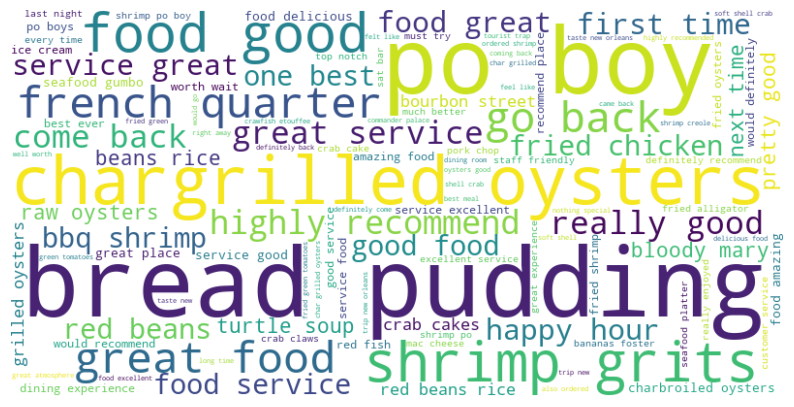

In [30]:
# Generate WordCloud image of other restaurants in same category
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white').generate_from_frequencies(word_scores)

# Display generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

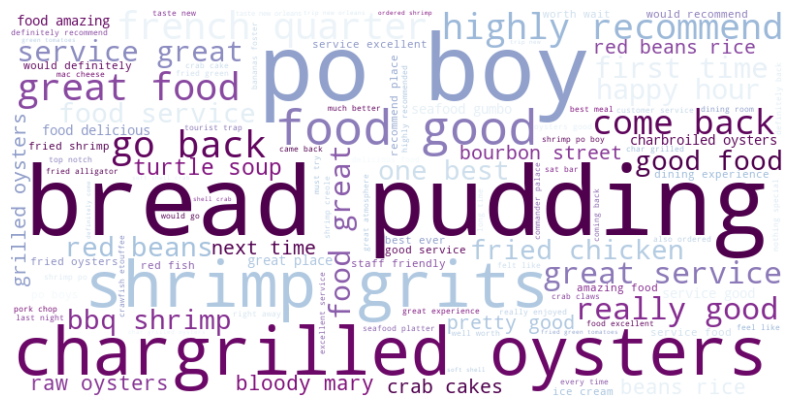

In [31]:
# Generate WordCloud image of user's restaurant
wordcloud = WordCloud(width=800, 
                      height=400,
                      colormap = 'BuPu_r',
                      background_color='white').generate_from_frequencies(sample_word_scores)

# Display generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

# **Put everything into a function!!!!**

### `wordcloud_other_res` function 

Goal: get the restaurant name from user to automatically generate a WordCloud of other restaurants in the same category 

In [35]:
def wordcloud_other_res(res_name:str) -> wordcloud:
    """
    Generate WordCloud of frequently mentioned keywords of 
    other restaurants in the same category 
    
    """
    # Filter out non-restaurant businesses
    new_orleans_restaurants = new_orleans_business[new_orleans_business['categories'].str.contains('restaurant', case=False, na=False)]
    
    
    # call res_in_same_cat() function to get a list of other restaurants in same category
    same_cat_restaurants = res_in_same_cat(res_name)
    
    # merge `new_orleans_reviews` with `same_cat_restaurants` on business_id 
    same_cat_reviews = pd.merge(new_orleans_reviews, same_cat_restaurants, on='business_id')
    
    # apply clean() function to process text column
    same_cat_reviews['clean_text'] = same_cat_reviews['text'].apply(clean)
    
    # Vectorize (tf-idf), ignoring terms that appear in less than 1% of all texts
    vectorizer = TfidfVectorizer(ngram_range=(2,3),
                                 min_df=0.01).fit(same_cat_reviews.clean_text)
    
    # transform same_cat_reviews into their tf-idf representation
    vectors = pd.DataFrame(vectorizer.transform(same_cat_reviews.clean_text).toarray(),
                      columns = vectorizer.get_feature_names_out())
    
    # frequency score
    sum_tfidf = vectors.sum(axis=0).sort_values(ascending=False)
    
    # convert series to list then sort list with scores (high to low)
    tfidf_list = [(word, sum_tfidf[word]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)
    
    # call remove_meaningless_words() function
    tfidf_list_clean = remove_meaningless_words(sorted_tfidf_list)
    
    # convert clean list of word scores to dictionary
    word_scores = dict(tfidf_list_clean) 
    
    # Generate WordCloud image of other restaurants in same category
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white').generate_from_frequencies(word_scores)

    # Display generated image
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

Cajun/Creole
CPU times: user 1min 6s, sys: 3.11 s, total: 1min 10s
Wall time: 1min 10s


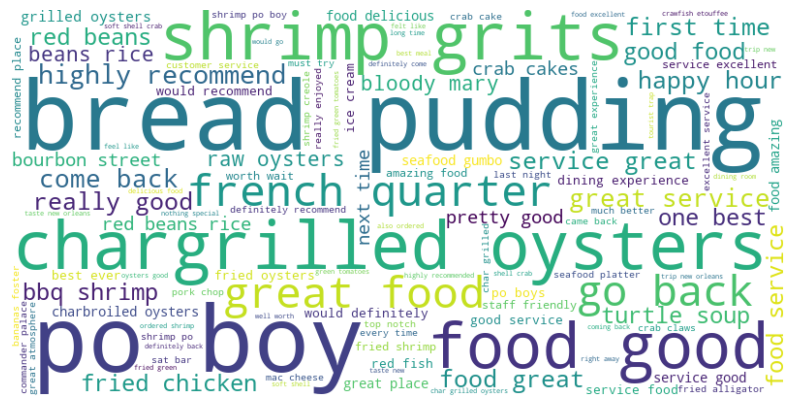

In [36]:
%%time
wordcloud_other_res("Mother's Restaurant") 

###  `wordcloud_of_res` function

Goal: Generate a WordCloud of frequently mentioned keywords of user's own restaurant

Remove non-restaurant businesses from `new_orleans_business` !!

In [43]:
def wordcloud_of_res(res_name:str) -> wordcloud:
    """
    Generate WordCloud of frequently mentioned keywords of user's own restaurant 
    
    """
    # Filter out non-restaurant businesses
    new_orleans_restaurants = new_orleans_business[new_orleans_business['categories'].str.contains('restaurant', case=False, na=False)]
    
    # retrieve user's restaurant from `new_orleans_restaurants` as a dataframe
    user_restaurant = new_orleans_restaurants[new_orleans_restaurants['name'] == res_name]
    
    # merge `new_orleans_reviews` with `user_restaurant` on `business_id`
    user_restaurant_reviews = pd.merge(new_orleans_reviews, user_restaurant, on='business_id')
    
    # apply clean() function to process text column
    user_restaurant_reviews['clean_text'] = user_restaurant_reviews['text'].apply(clean)
    
    # transform user_restaurant_reviews into their tf-idf representation
    vectors = pd.DataFrame(vectorizer.transform(user_restaurant_reviews.clean_text).toarray(),
                      columns = vectorizer.get_feature_names_out())
    
    # sum the frequency score
    sum_tfidf = vectors.sum(axis=0).sort_values(ascending=False)
    
    # convert series to list then sort list with scores (high to low)
    tfidf_list = [(word, sum_tfidf[word]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)
    
    # call remove_meaningless_words() function
    tfidf_list_clean = remove_meaningless_words(sorted_tfidf_list)
    
    # convert clean list of word scores to dictionary
    word_scores = dict(tfidf_list_clean) 
    
    # Generate WordCloud image of other restaurants in same category
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          colormap = 'BuPu_r',
                          background_color='white').generate_from_frequencies(word_scores)

    # Display generated image
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

CPU times: user 2.81 s, sys: 153 ms, total: 2.96 s
Wall time: 2.96 s


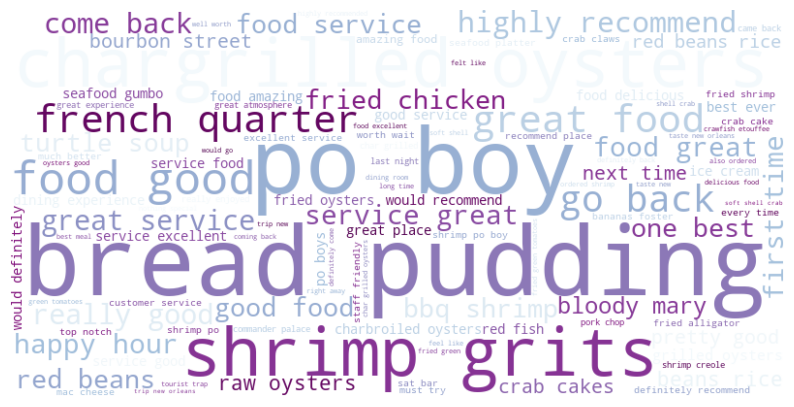

In [44]:
%%time
wordcloud_of_res("Mother's Restaurant") 